# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "2n_2m_0f_240214_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [60, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 110884
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,658.013667,89.169044,665.626398,90.391465,0.0,667.000000,43.000000,0.631373,573.000000,118.000000,-1.427848,15073.0,242.545246,96.323261,0.917760,4
1,1,0,1457.736234,652.648191,1445.808666,660.305997,NaN,1457.736234,652.648191,NaN,1457.736234,652.648191,-0.903196,13766.0,252.641976,87.712674,0.937798,4
2,2,0,510.450890,1057.829443,513.020131,1057.836541,0.0,398.000000,1041.000000,0.917647,532.000000,1054.000000,1.535741,4327.0,256.382167,40.429567,0.987488,4
3,3,0,1309.042743,1067.225735,1308.201310,1067.257820,0.0,1371.000000,1051.000000,0.517647,1293.000000,1064.000000,-1.534050,2246.0,135.878803,27.900335,0.978692,4


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1]
    ])

    cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
    print("Initial tracking at time 0:\n", tracking_0[cols])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         4   658.013667   89.169044     1.427848
1   1     0         4  1457.736234  652.648191     0.903196


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,658.013667,89.169044,665.626398,90.391465,0.0,667.000000,43.000000,0.631373,573.000000,118.000000,1.427848,15073.0,242.545246,96.323261,0.917760,4
1,1,0,1457.736234,652.648191,1445.808666,660.305997,NaN,1457.736234,652.648191,NaN,1457.736234,652.648191,0.903196,13766.0,252.641976,87.712674,0.937798,4
4,0,3,657.981760,89.167903,665.724815,90.386978,0.0,668.000000,43.000000,0.670588,670.000000,121.000000,-1.428990,14967.0,242.593095,96.150788,0.918101,5
5,1,3,1464.218260,648.672042,1453.500548,655.885616,NaN,1464.218260,648.672042,NaN,1464.218260,648.672042,-0.891433,13209.0,248.210183,86.275205,0.937647,5
6,2,3,1602.764590,1036.535114,1601.955882,1036.641449,0.0,1638.000000,1029.000000,0.400000,1585.000000,1035.000000,-1.492975,1011.0,109.766575,16.509297,0.988625,5


In [7]:
df_tracked.tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
2604,7,92295,1299.872543,1064.440710,1298.951581,1064.460573,0.0,1348.0,1047.0,0.529412,1246.0,1057.0,-1.556496,3154.0,142.297630,35.440294,0.968489,8
2619,7,92301,1299.227671,1064.426762,1298.286611,1064.446954,0.0,1348.0,1047.0,0.529412,1263.0,1057.0,-1.556415,3079.0,144.275368,35.360462,0.969500,8
29843,8,57609,1297.260672,1064.358765,1296.420419,1064.356043,0.0,1308.0,1049.0,0.529412,1323.0,1056.0,1.551085,2202.0,135.750743,35.064138,0.966065,10
34240,8,85401,1301.562793,1064.828022,1300.831512,1064.839824,0.0,1311.0,1048.0,0.521569,1252.0,1064.0,-1.553312,2134.0,127.900436,36.454400,0.958521,9
29844,9,57609,1025.192703,1069.069373,1024.840345,1069.048103,0.0,1008.0,1057.0,0.619608,989.0,1060.0,1.525783,1946.0,109.048388,23.956879,0.975570,10


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


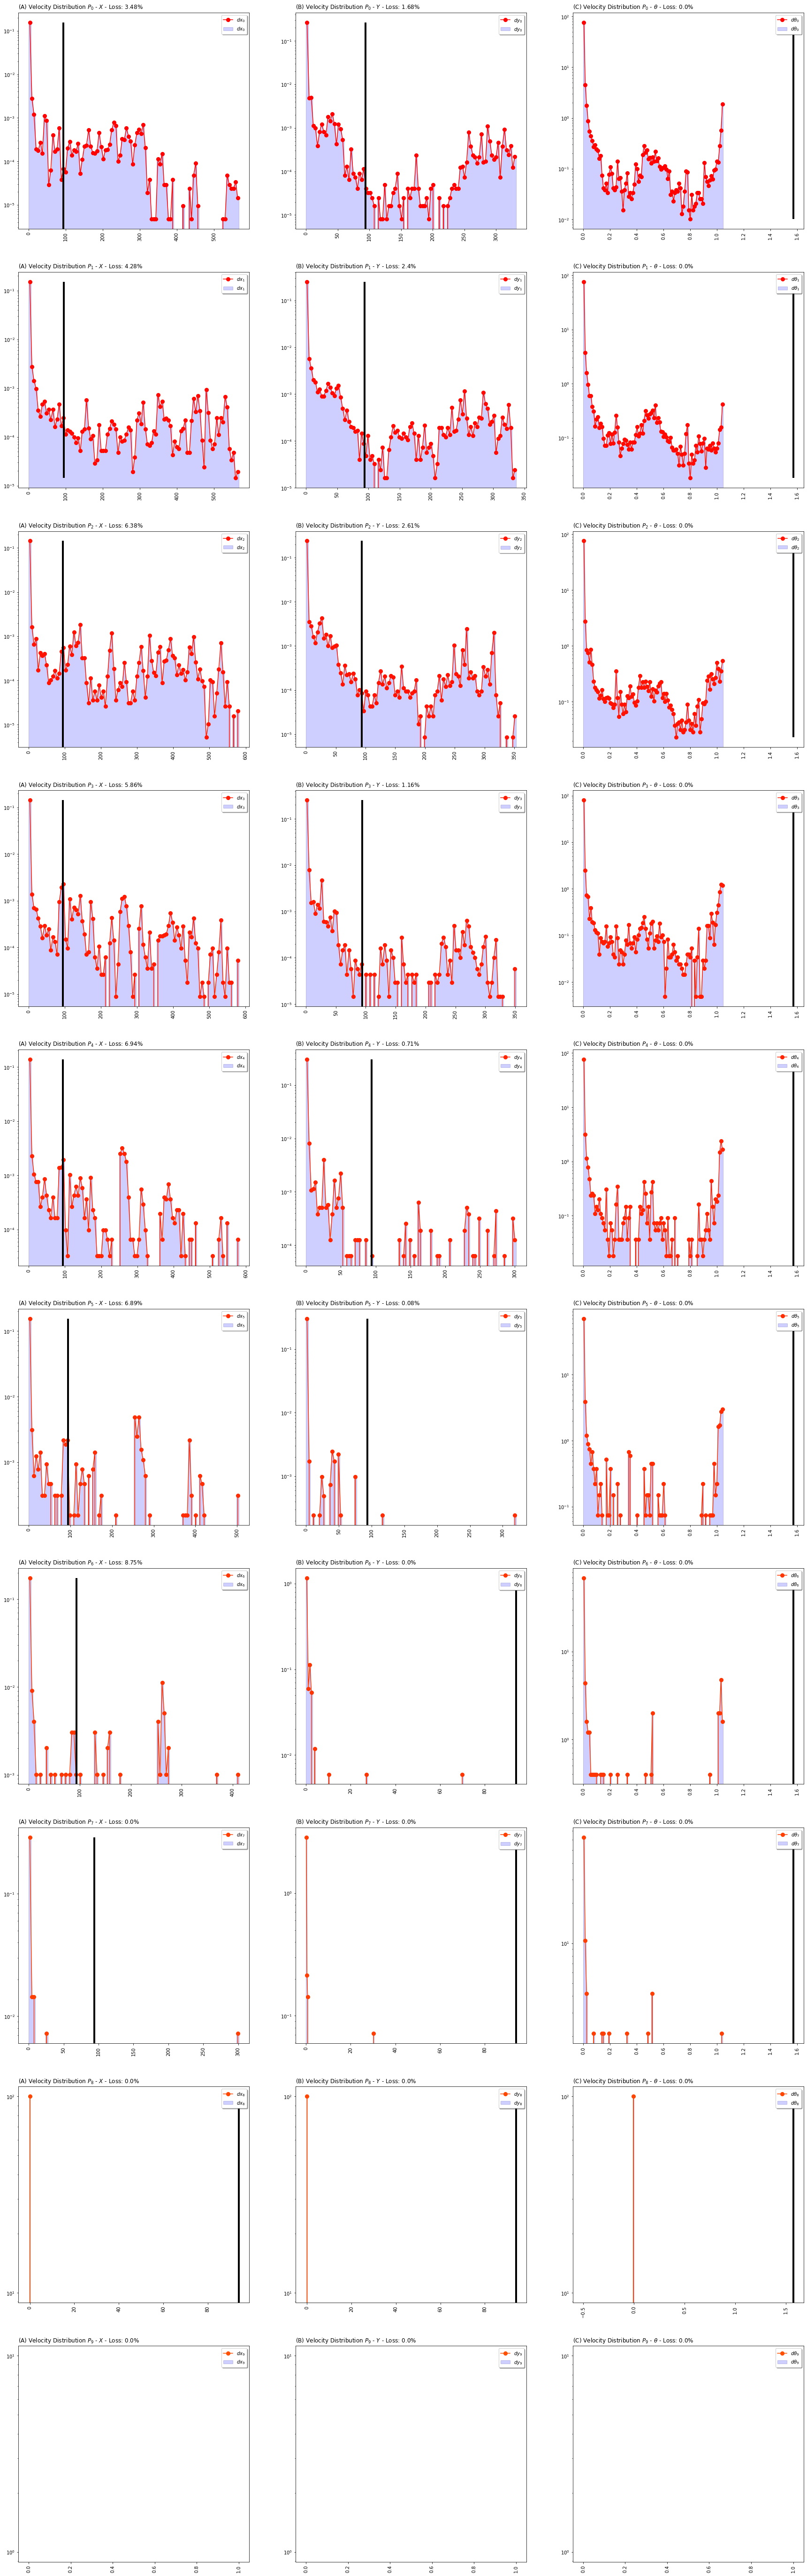

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,1,18
1,2,7554
2,3,40815
3,4,57266
4,5,19840
5,6,6222
6,7,1351
7,8,360
8,9,9
9,10,10


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 53.20914545909328 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,0.012739
1,1,True,True,False,0.000749
2,2,False,False,False,5.205141
3,2,False,True,False,0.146128
4,2,True,False,False,0.208326
5,2,True,True,False,0.101165
6,3,False,False,False,28.862078
7,3,False,True,False,0.565776
8,3,True,False,False,0.880513
9,3,True,True,False,0.277268


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 1.6276110384892075 
	- Angle: 53.20914545909328 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 4.8449278626409304%
Final loss data X-axis: 7.265404538890581%
Final loss data Y-axis: 6.874577708297452%
Final loss data Angle : 0.6756667240762577%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,0.001325
1,1,True,True,True,0.002650
2,2,False,False,False,0.129834
3,2,False,False,True,3.225977
4,2,False,True,False,0.186802
5,2,False,True,True,2.770234
6,2,True,False,False,0.006624
7,2,True,False,True,2.900068
8,2,True,True,False,0.166929
9,2,True,True,True,85.768604


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 1.6276110384892075 
	- Angle: 53.20914545909328 



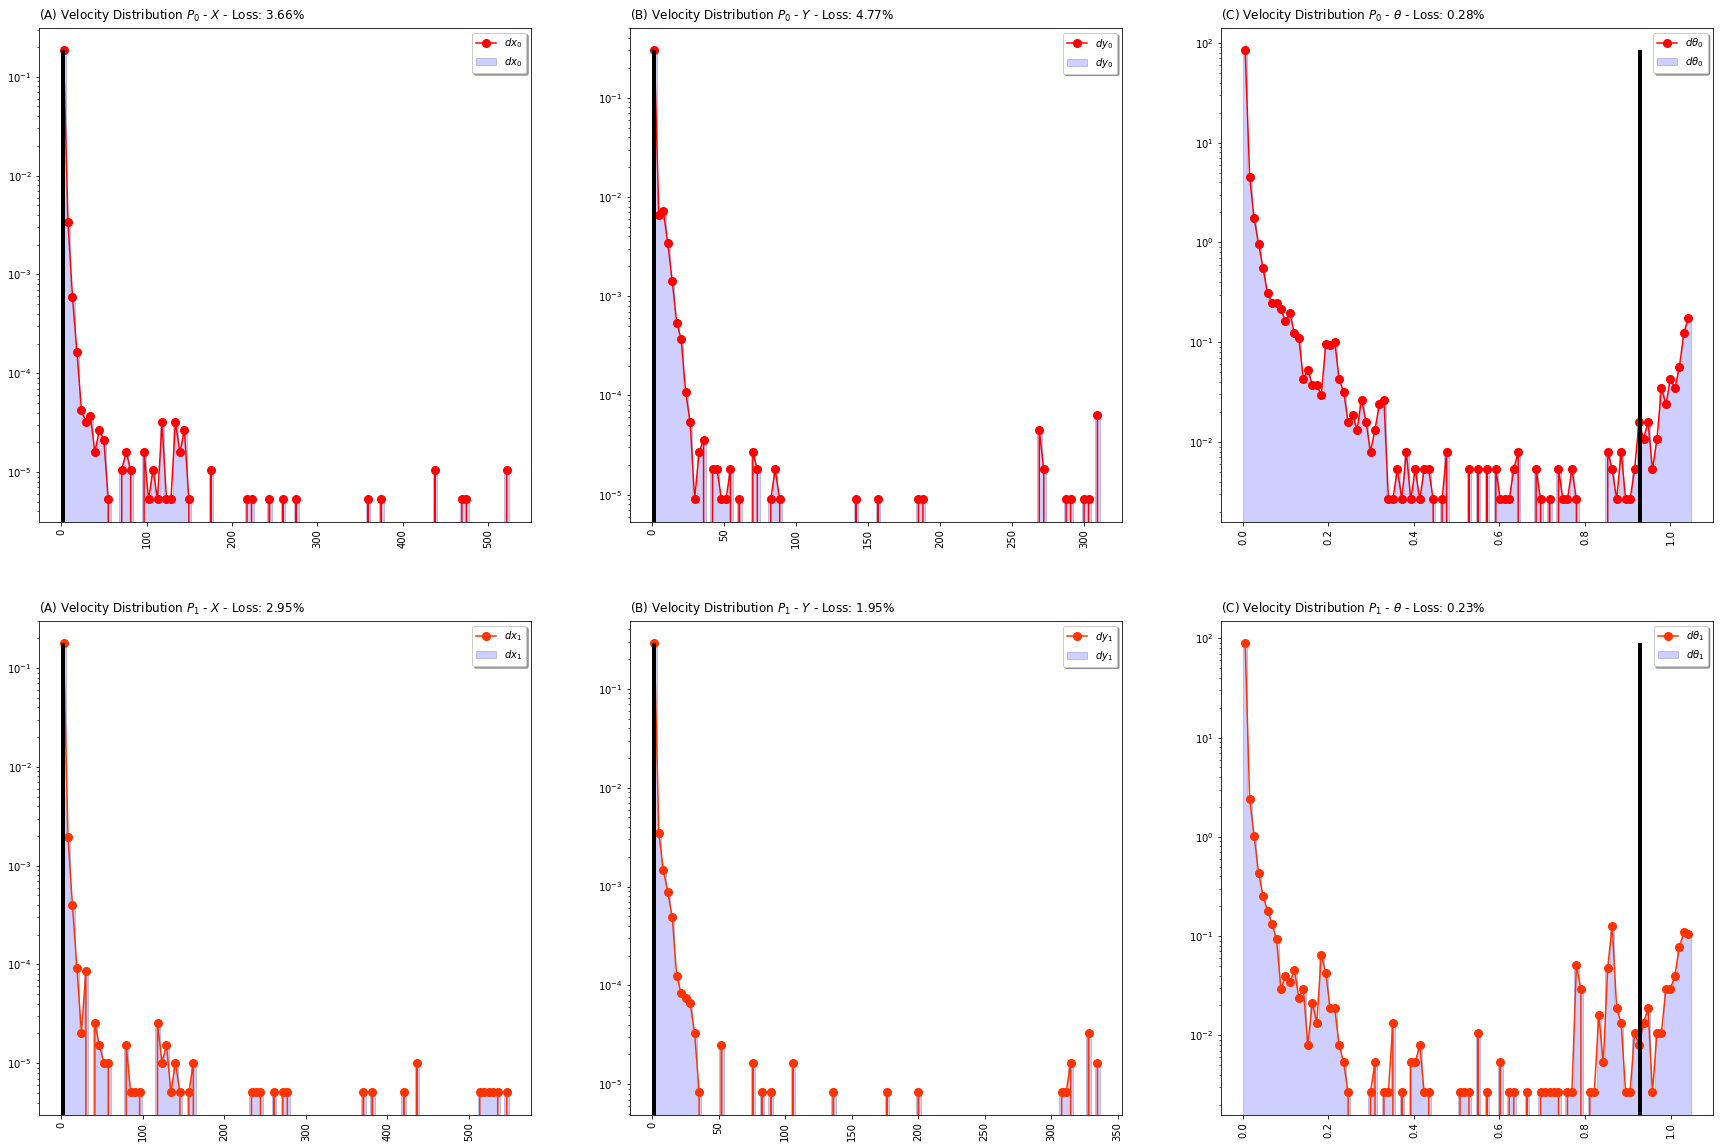

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,658.013667,89.169044,665.626398,90.391465,0.0,667.000000,43.000000,0.631373,573.000000,118.000000,1.427848,15073.0,242.545246,96.323261,0.917760,2,NaN,NaN,NaN,NaN,False,False,False
3775,1,0,1457.736234,652.648191,1445.808666,660.305997,NaN,1457.736234,652.648191,NaN,1457.736234,652.648191,0.903196,13766.0,252.641976,87.712674,0.937798,2,NaN,NaN,NaN,NaN,False,False,False
7551,0,3,657.981760,89.167903,665.724815,90.386978,0.0,668.000000,43.000000,0.670588,670.000000,121.000000,-1.428990,14967.0,242.593095,96.150788,0.918101,2,3.0,-0.010636,-0.000380,-0.952279,False,False,False
7552,1,3,1464.218260,648.672042,1453.500548,655.885616,NaN,1464.218260,648.672042,NaN,1464.218260,648.672042,-0.891433,13209.0,248.210183,86.275205,0.937647,2,3.0,2.160675,-1.325383,-0.598210,True,False,False
7553,0,6,657.649442,89.198293,665.302226,90.474820,0.0,668.000000,43.000000,0.709804,734.000000,118.000000,-1.430973,14882.0,241.613159,95.987414,0.917699,2,3.0,-0.110773,0.010130,-0.000661,False,False,False
7554,1,6,1470.228406,645.297105,1458.847168,652.669749,NaN,1470.228406,645.297105,NaN,1470.228406,645.297105,-0.937379,12955.0,252.659470,87.011360,0.938830,2,3.0,2.003382,-1.124979,-0.015315,True,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/2n_2m_0f_240214_1_c.zip'